# Coefficient Estimation for NEWT

At this point, we have established that, with the available periods-of-record, a stationary SCHEMA works quite well, though some sort of dynamism is likely to help with longer-range applications.  Still, the emphasis is on short-term and S2S forecasting, so long-range efficiency isn't critical (and, more to the point, can be returned to later).  Now, let's look at coefficient estimation, where dynamic fitting is likely to be more important.

Here's the basic idea.  We want to be able to run a watershed model without pre-feeding years of data, but we also want to benefit from data on atmospheric conditions.  How should we proceed?

- Develop one fit for model coefficients based only on static surface conditions (XYZ, slope and aspect, land cover/LAI, drainage area)
- Develop a separate fit for model coefficients based only on dynamic conditions (mean precipitation, temperature, and humidity; land cover/LAI again; soil moisture; aridity)
- Tune two "drift rates": climate drift (rate of convergence from static-only to climate-only; possibly with a final equilibrium weighting), and recency weight (weighting of climate over time, controlling speed of correction for climate shifts)

For early reporting, I will prototype this with a single model accounting for all data.  Then, I'll build a static-only watershed model generator and a climate-drift model modification engine for the final implementation.

Data requirements:

- Model fits (have)
- Weather data (have)
- Land cover/LAI (have)
- Soil moisture (need)
- Topography summaries (have)
- Aridity (need)

In [1]:
import pandas as pd
import pandas.plotting as pdp
import numpy as np
import matplotlib.pyplot as plt
import rtseason as rts
import seaborn as sns
import scipy
from sklearn.decomposition import PCA
import pygam  # https://pygam.readthedocs.io/en/latest/notebooks/tour_of_pygam.html
from pygam import LinearGAM, s, te, l, f
from NEWT import Watershed, kfold, perf_summary, statics

In [2]:
def idfix(data):
    data = data[data["id"].apply(lambda x: x.startswith("USGS"))]
    data["id"] = data["id"].apply(lambda x: x.split("_")[1])
    return data

In [12]:
# sillymod: use one generic model.  Otherwise, fit each model to itself.
def dummy_modbuilder(data, sillymod):
    data = data.groupby("date")[["temperature", "tmax", "vp"]].mean().assign(date = lambda x: x.index)
    def runner(ws):
        try:
            if sillymod:
                return Watershed.from_data(data).run_series(ws)
            else:
                return Watershed.from_data(ws).run_series(ws)
        except Exception as e:
            print(e)
    return runner

In [3]:
data = pd.read_csv("AllData.csv", dtype={"id": "str"}).rename(columns={"temperature.mean": "temperature"})
data["date"] = pd.to_datetime(data["date"])
data["day"] = data["date"].dt.day_of_year
gsamp = pd.read_csv(r"C:\Users\dphilippus\OneDrive - Colorado School of Mines\PhD\NEXT\DataRetrieval\GageSample.csv",
                   dtype={"id": "str"})
lcov = idfix(pd.read_csv("LandCover.csv"))
area = idfix(pd.read_csv("Area.csv"))
topo = idfix(pd.read_csv("Topography.csv"))
data = data.merge(lcov, on="id").merge(area, on="id").merge(topo, on="id").merge(gsamp[["id", "lat", "lon"]], on="id")
data

,id,date,temperature,prcp,srad,swe,tmax,tmin,vp,day,...,wetland,ice_snow,area,elev,elev_min,elev_std,slope,asp,lat,lon
0,13011820,2020-03-31,0.100000,17.110126,248.76216,NaN,1.795443,NaN,444.26370,91,...,0.040230,0.0,7.993837e+07,2868.2670,2549.556152,130.430969,NaN,NaN,43.807111,-110.178722
1,13011820,2020-04-01,0.100000,7.202532,403.38873,NaN,0.030759,NaN,270.94354,92,...,0.040230,0.0,7.993837e+07,2868.2670,2549.556152,130.430969,NaN,NaN,43.807111,-110.178722
2,13011820,2020-04-02,0.100000,2.167848,600.86993,NaN,-3.442405,NaN,132.77936,93,...,0.040230,0.0,7.993837e+07,2868.2670,2549.556152,130.430969,NaN,NaN,43.807111,-110.178722
3,13011820,2020-04-03,0.100000,2.987468,509.44165,NaN,-2.238481,NaN,138.35303,94,...,0.040230,0.0,7.993837e+07,2868.2670,2549.556152,130.430969,NaN,NaN,43.807111,-110.178722
4,13011820,2020-04-04,0.100000,6.021518,465.97583,NaN,3.509114,NaN,284.43704,95,...,0.040230,0.0,7.993837e+07,2868.2670,2549.556152,130.430969,NaN,NaN,43.807111,-110.178722
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2992992,03047000,2022-12-27,0.540625,0.000000,268.23563,NaN,-2.151775,NaN,207.79785,361,...,0.003176,0.0,6.878668e+08,457.4157,257.871948,133.578278,NaN,NaN,40.458889,-79.449444
2992993,03047000,2022-12-28,0.407292,0.000000,279.93356,NaN,5.509683,NaN,310.02664,362,...,0.003176,0.0,6.878668e+08,457.4157,257.871948,133.578278,NaN,NaN,40.458889,-79.449444
2992994,03047000,2022-12-29,0.428125,0.000000,290.53482,NaN,13.100331,NaN,354.31638,363,...,0.003176,0.0,6.878668e+08,457.4157,257.871948,133.578278,NaN,NaN,40.458889,-79.449444
2992995,03047000,2022-12-30,0.661458,0.000000,285.53320,NaN,17.568270,NaN,512.88240,364,...,0.003176,0.0,6.878668e+08,457.4157,257.871948,133.578278,NaN,NaN,40.458889,-79.449444


## A Silly Kfold Test

First we need to test the cross-validation setup, so we have a dummy model to test it with.  One option is to use a model that's just trained on everything.  The other option is to use a model that's trained on each watershed to predict itself.

In [5]:
silly = kfold(data, lambda x: dummy_modbuilder(x, True), output="results/Silly.csv")
cheat = kfold(data, lambda x: dummy_modbuilder(x, False), output="results/Cheat.csv")

In [6]:
silly.groupby("id").apply(perf_summary, include_groups=False).median()

R2         0.927358
RMSE       2.889678
NSE        0.810347
Pbias      2.989468
Bias       0.369906
MaxMiss    1.845938
dtype: float64

## Prepare Coefficients

Since the kfold testing seems to be working, let's prepare model coefficients.  To recap, we need to provide seasonality coefficients, tmax and vp sensitivities, and tmax and vp dailies (for static/spin-up).  We can also set up dynamic and yearly modification engines, and will eventually separate estimators into static (at start) and climate/dynamic (through a climate modification engine), but that can come later.

A brief test was run and subsequently deleted to establish that simple sinusoid (annual-period, variable-phase sine) does a solid job capturing vp and tmax annual cycles (median R2 0.95 and 0.92, respectively), and therefore those coefficients are suitable here.

In [7]:
coefs = data.groupby("id").apply(lambda x: (
    pd.concat([
        Watershed.from_data(x).coefs_to_df().drop(columns=["R2", "RMSE"]),
        statics.fit_simple_daily(x, "tmax", True).\
        merge(statics.fit_simple_daily(x, "vp", True), how="cross", suffixes=("_tm", "_vp"))
    ], axis=1)
) if len(x[["day", "temperature"]].dropna()["day"].unique()) >= 181 else None, include_groups=False)
coefs.index = coefs.index.get_level_values("id")
coefs

,Intercept,Amplitude,FallDay,WinterDay,SpringDay,SummerDay,SpringSummer,FallWinter,at_coef,vp_coef,intercept_tm,ksin_tm,kcos_tm,intercept_vp,ksin_vp,kcos_vp
id,,,,,,,,,,,,,,,,
01010000,8.227527,11.664508,323.0,27.5,120.0,236.0,1.989669,3.269881,0.275727,0.001378,8.787829,-6.067253,-15.167896,693.766616,-266.789732,-570.140506
01011000,8.547659,11.735706,322.0,27.0,120.0,204.0,2.563314,2.746746,0.255334,0.001096,9.763696,-5.932321,-14.604735,699.838476,-263.185827,-560.410490
01018035,9.074948,12.007753,321.0,28.0,120.0,206.0,1.838306,2.569034,0.315614,0.001516,11.344458,-5.606314,-14.288229,766.456060,-289.078520,-584.337550
01038000,10.871231,12.433309,319.0,27.0,169.0,200.0,0.899632,1.966065,0.333966,0.001423,12.411499,-5.377854,-12.851322,880.149454,-319.869872,-646.207066
010642505,8.232986,9.252760,321.0,26.0,122.0,233.0,1.766506,1.030557,0.271311,0.001534,10.084860,-5.104671,-12.878405,718.774950,-241.243771,-548.664202
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385903107210800,7.163091,9.258731,300.0,87.0,143.0,201.0,2.083604,1.409694,0.478011,-0.000085,11.893447,-4.284127,-11.356781,574.381380,-190.504921,-319.363068
394220106431500,6.965011,7.357272,324.0,84.0,156.0,237.0,2.823831,1.979052,0.307356,0.000265,9.466164,-3.972916,-10.774711,516.589866,-135.047240,-276.552819
402114105350101,4.352286,7.339022,301.0,88.0,153.0,237.0,2.495065,0.984321,0.384537,0.000378,6.876817,-4.462743,-11.078878,476.261802,-147.476692,-304.520152


In [15]:
coefs.corr()

,Intercept,Amplitude,FallDay,WinterDay,SpringDay,SummerDay,SpringSummer,FallWinter,at_coef,vp_coef,intercept_tm,ksin_tm,kcos_tm,intercept_vp,ksin_vp,kcos_vp
Intercept,1.000000,0.087094,0.168131,0.368204,0.324701,0.118031,-0.126292,0.086805,-0.055153,0.487779,0.735301,0.491618,0.316336,0.623298,-0.305323,-0.420201
Amplitude,0.087094,1.000000,-0.377537,0.273869,-0.067101,-0.271086,-0.227748,0.472257,0.453893,0.058314,-0.018569,-0.310002,-0.587390,0.063076,-0.478376,-0.434878
FallDay,0.168131,-0.377537,1.000000,-0.143717,0.102672,0.354318,0.043403,-0.407274,-0.310416,-0.053592,0.233559,0.246466,0.279176,0.149529,0.091839,0.029330
WinterDay,0.368204,0.273869,-0.143717,1.000000,0.424919,-0.199596,-0.323925,0.209612,0.353000,0.166050,0.395433,0.156092,0.047770,0.294704,-0.260172,-0.310692
SpringDay,0.324701,-0.067101,0.102672,0.424919,1.000000,0.148042,-0.224463,0.021307,0.162912,0.064498,0.424221,0.409479,0.277801,0.359283,-0.139890,-0.221989
SummerDay,0.118031,-0.271086,0.354318,-0.199596,0.148042,1.000000,0.157056,-0.443811,-0.215468,-0.094063,0.130819,0.234841,0.271242,0.188233,-0.066512,-0.074314
SpringSummer,-0.126292,-0.227748,0.043403,-0.323925,-0.224463,0.157056,1.000000,-0.117596,-0.546726,0.208749,-0.507914,-0.206541,-0.029938,-0.488457,0.363564,0.445504
FallWinter,0.086805,0.472257,-0.407274,0.209612,0.021307,-0.443811,-0.117596,1.000000,0.365754,0.126217,0.027942,-0.046979,-0.233083,-0.112976,-0.024488,0.052592
at_coef,-0.055153,0.453893,-0.310416,0.353000,0.162912,-0.215468,-0.546726,0.365754,1.000000,-0.517395,0.311382,0.148405,0.022100,0.303682,-0.323607,-0.316742
vp_coef,0.487779,0.058314,-0.053592,0.166050,0.064498,-0.094063,0.208749,0.126217,-0.517395,1.000000,0.013892,-0.014610,-0.089812,0.077106,-0.138639,-0.132052


## PCA

In [73]:
co_norm = (coefs - coefs.mean()) / coefs.std()
co_norm.iloc[:, :10]

,,Intercept,Amplitude,FallDay,WinterDay,SpringDay,SummerDay,SpringSummer,FallWinter,at_coef,vp_coef
id,,,,,,,,,,,
01010000,0,-0.943126,1.020460,-0.239062,-1.207480,-1.574790,1.057523,1.185340,2.035952,-0.495313,0.335223
01011000,0,-0.874865,1.046572,-0.303112,-1.222831,-1.574790,-0.790702,1.723365,1.467359,-0.592296,0.137413
01018035,0,-0.762433,1.146347,-0.367163,-1.192130,-1.574790,-0.675188,1.043375,1.274206,-0.305630,0.431983
01038000,0,-0.379418,1.302420,-0.495264,-1.222831,0.691799,-1.021730,0.162987,0.618842,-0.218354,0.366795
010642505,0,-0.941962,0.135945,-0.367163,-1.253531,-1.482276,0.884252,0.976034,-0.397956,-0.516314,0.444743
...,...,...,...,...,...,...,...,...,...,...,...
385903107210800,0,-1.170092,0.138135,-1.712223,0.619173,-0.510881,-0.963973,1.273442,0.014126,0.466665,-0.691027
394220106431500,0,-1.212328,-0.559231,-0.175011,0.527073,0.090459,1.115280,1.967705,0.632957,-0.344901,-0.445304
402114105350101,0,-1.769430,-0.565924,-1.648173,0.649873,-0.048312,1.115280,1.659354,-0.448210,0.022142,-0.365879


There are some nontrivial cross-correlations, so let's see what the principal component axes look like.  Let's limit it to stream properties (10 variables).

In [74]:
pca = PCA()
fit = pca.fit(co_norm.iloc[:, :10])
evr = fit.explained_variance_ratio_
print(evr)
print(np.cumsum(evr))

[0.28635317 0.19484294 0.16747634 0.07725998 0.07444256 0.05951356
 0.0512307  0.0416597  0.03223543 0.01498563]
[0.28635317 0.48119611 0.64867245 0.72593242 0.80037498 0.85988854
 0.91111925 0.95277894 0.98501437 1.        ]


Compared to 10 coefficients, we can capture ~95% of the variance with 8 components.  6 components capture 86%.  Doesn't really seem worth pursuing.

<Axes: >

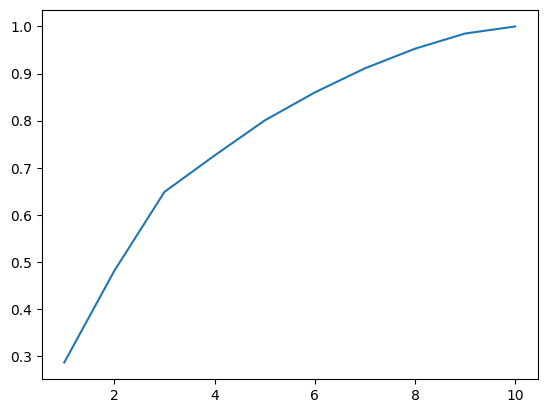

In [75]:
sns.lineplot(x=np.arange(1, len(evr)+1), y=np.cumsum(evr))

## Coefficient Correlations

### Geography

What's predictable from linear XYZ (plus squared longitude, which gives access to "coasts vs middle")?

In [98]:
coef_xyz = coefs.merge(data[["lat", "lon", "elev", "id"]].groupby("id").mean(), on="id").assign(lon2 = lambda x: (x["lon"] - x["lon"].mean())**2)
coef_xyz

,Intercept,Amplitude,FallDay,WinterDay,SpringDay,SummerDay,SpringSummer,FallWinter,at_coef,vp_coef,intercept_tm,ksin_tm,kcos_tm,intercept_vp,ksin_vp,kcos_vp,lat,lon,elev,lon2
id,,,,,,,,,,,,,,,,,,,,
01010000,8.227527,11.664508,323.0,27.5,120.0,236.0,1.989669,3.269881,0.275727,0.001378,8.787829,-6.067253,-15.167896,693.766616,-266.789732,-570.140506,46.700556,-69.715556,421.54080,575.889748
01011000,8.547659,11.735706,322.0,27.0,120.0,204.0,2.563314,2.746746,0.255334,0.001096,9.763696,-5.932321,-14.604735,699.838476,-263.185827,-560.410490,47.069722,-69.079444,362.70602,606.824801
01018035,9.074948,12.007753,321.0,28.0,120.0,206.0,1.838306,2.569034,0.315614,0.001516,11.344458,-5.606314,-14.288229,766.456060,-289.078520,-584.337550,46.181111,-67.803889,175.52219,671.295438
01038000,10.871231,12.433309,319.0,27.0,169.0,200.0,0.899632,1.966065,0.333966,0.001423,12.411499,-5.377854,-12.851322,880.149454,-319.869872,-646.207066,44.222778,-69.593889,109.47253,581.743994
010642505,8.232986,9.252760,321.0,26.0,122.0,233.0,1.766506,1.030557,0.271311,0.001534,10.084860,-5.104671,-12.878405,718.774950,-241.243771,-548.664202,44.083889,-71.285556,704.23030,503.001861
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385903107210800,7.163091,9.258731,300.0,87.0,143.0,201.0,2.083604,1.409694,0.478011,-0.000085,11.893447,-4.284127,-11.356781,574.381380,-190.504921,-319.363068,38.988361,-107.348489,2647.72120,185.919506
394220106431500,6.965011,7.357272,324.0,84.0,156.0,237.0,2.823831,1.979052,0.307356,0.000265,9.466164,-3.972916,-10.774711,516.589866,-135.047240,-276.552819,39.705000,-106.725833,3027.49410,169.327101
402114105350101,4.352286,7.339022,301.0,88.0,153.0,237.0,2.495065,0.984321,0.384537,0.000378,6.876817,-4.462743,-11.078878,476.261802,-147.476692,-304.520152,40.353861,-105.584139,3229.42850,140.917800


Intercept, Amplitude, SpringSummer, and air temperature variation are partially explained by XYZ, while mean air temperature and all of humidity are quite well explained.  Seasonality dates are very poorly explained.

In [99]:
coef_xyz.corr()[["lat", "lon", "elev", "lon2"]]**2

,lat,lon,elev,lon2
Intercept,0.434484,0.062616,0.170895,0.093716
Amplitude,0.000220,0.244220,0.061939,0.256083
FallDay,0.040251,0.000045,0.009747,0.024269
WinterDay,0.153067,0.048174,0.016780,0.087998
SpringDay,0.167345,0.007364,0.020012,0.022196
SummerDay,0.030443,0.001409,0.002904,0.000012
SpringSummer,0.178378,0.173442,0.234462,0.108312
FallWinter,0.002045,0.010155,0.021177,0.047704
at_coef,0.089587,0.057666,0.034808,0.094770
vp_coef,0.000768,0.028166,0.023897,0.002728


# General Additive Stationary Model

For preliminary prototyping, we'll use a GAM and see if we can pull some bits out later.  This lets us test a broad range of relationships while keeping it quick and interpretable, and has precedent in the literature (PNW from Siegel et al at NOAA Northwestern Fisheries).  For now, we'll just make a "big model of all the variables", one at a time.

For the stationary model, weather summaries are predictors, not dependent variables.

## Generalized Code

In [17]:
data.columns

Index(['id', 'date', 'temperature', 'prcp', 'srad', 'swe', 'tmax', 'tmin',
       'vp', 'day', 'water', 'developed', 'barren', 'forest', 'shrubland',
       'herbaceous', 'cultivated', 'wetland', 'ice_snow', 'area', 'elev',
       'elev_min', 'elev_std', 'slope', 'asp', 'lat', 'lon'],
      dtype='object')

In [9]:
predictors = data.groupby("id")[["prcp", "srad", "water", "developed", "barren", "forest", "shrubland", "herbaceous", "cultivated", "wetland", "ice_snow", "area", "elev", "elev_min", "elev_std", "lat", "lon"]].mean()
pmonthlies = data.assign(month = lambda x: x["date"].dt.month).groupby(["id", "month"])[["prcp", "srad", "tmax", "vp"]].mean().unstack(1)
pmonthlies.columns = [f"{x[0]}_{x[1]}" for x in pmonthlies.columns]
pds = coefs.merge(predictors, on="id").dropna().\
    assign(tamp = lambda x: np.sqrt(x["ksin_tm"]**2 + x["kcos_tm"]**2),
           hamp = lambda x: np.sqrt(x["ksin_vp"]**2 + x["kcos_vp"]**2))
pds["atmax"] = pds["intercept_tm"] + pds["tamp"]
pds["atmin"] = pds["intercept_tm"] - pds["tamp"]
pds["vpmax"] = pds["intercept_vp"] + pds["hamp"]
pds["vpmin"] = pds["intercept_vp"] - pds["hamp"]
Xpd = pds.iloc[:, 10:]
cols = Xpd.columns
Xall = Xpd.to_numpy()
Xmo = pds.merge(pmonthlies, on="id").dropna()
Xpdmo = Xmo.loc[:, 'intercept_tm':]

In [434]:
# Reference linear model
X = np.concatenate((np.ones((len(Xpdmo), 1)), Xpdmo.to_numpy()), axis=1)
y = Xmo.iloc[:, :10]
fit = np.linalg.lstsq(X, y, rcond=None)[0]
prd = X @ fit
pd.concat([
    pd.DataFrame({"R2": np.corrcoef(y.iloc[:, i], prd[:, i])[0, 1]**2}, index=[y.columns[i]])
    for i in range(len(y.columns))
])

,R2
Intercept,0.604156
Amplitude,0.617395
FallDay,0.289992
WinterDay,0.450279
SpringDay,0.454403
SummerDay,0.320814
SpringSummer,0.510411
FallWinter,0.431027
at_coef,0.338838
vp_coef,0.182578


Naive GAM performance comparison:

- Intercept: outperforms linear with r2 = 0.8
- Amplitude: marginally outperforms linear with r2 = 0.64
- SpringSummer: marginally outperforms linear with r2 = 0.57
- FallWinter: outperforms linear with r2 = 0.56
- SpringDay: barely outperforms linear with r2 = 0.48
- SummerDay: outperforms linear with r2 = 0.40
- FallDay: outperforms linear with r2 = 0.42
- WinterDay: marginally outperforms linear with r2 = 0.51
- at_coef: dramatically outperforms linear with r2 = 0.68
- vp_coef: dramatically outperforms linear with r2 = 0.76

In [5]:
def build_eq(n, latlon):
    base = te(0, 1, lam=0.1) if latlon else s(0)
    for i in range(2 if latlon else 1, n):
        base += s(i)
    return base

def runit(x, y, latlon, keep=[], previous=None, previous_r2=None, threshold=0.02):
    if latlon and keep == []:
        keep = ["lat", "lon"]
    builder = lambda col: LinearGAM(build_eq(len(keep) + 1, latlon)).fit(x[keep + [col]], y)
    fits = pd.concat([
        pd.DataFrame({"r2": stat["pseudo_r2"]["explained_deviance"], "GCV": stat["GCV"], "AIC": stat["AIC"]}, index=[col])
        for col in x.columns
        for stat in [builder(col).statistics_]
        if not col in keep
    ]).sort_values("r2", ascending=False)
    best = fits.iloc[0]
    vr = best.name
    [r2, gcv, aic] = best
    delta = r2 - previous_r2 if previous_r2 is not None else 0
    df = pd.DataFrame({"r2": r2, "gcv": gcv, "aic": aic, "delta_r2": delta}, index=[vr])
    if previous is not None:
        df = pd.concat([previous, df])
    if previous_r2 is not None and delta < threshold:
        best_gam = builder(vr)
        print(df.sort_values("r2", ascending=False))
        return best_gam
    else:
        print(f"Added {vr} with delta {delta: .3f}")
        return runit(x, y, latlon, keep + [vr], df, r2, threshold)

def pdps(gam, xy0=True):
    nt = len(gam.terms)
    Ny = 2 if nt < 9 else 3
    Nx = nt // Ny + (1 if nt % Ny > 0 else 0)
    _, axes = plt.subplots(Ny, Nx, figsize=(12,8))
    for i, term in enumerate(gam.terms):
        if term.isintercept:
            continue
        ax = axes[i // Nx, i % Nx]
        if i == 0 and xy0:
            XX = gam.generate_X_grid(term=i, meshgrid=True)
            Z = gam.partial_dependence(term=1, X=XX, meshgrid=True)
            co = ax.contourf(XX[1], XX[0], Z)
            
        else:
            XX = gam.generate_X_grid(term=i)
            pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)
    
            ax.plot(XX[:, term.feature], pdep)
            ax.plot(XX[:, term.feature], confi, c='r', ls='--')
        ax.set_title(repr(term))



## PCA... over predictors?

PCA over coefficients didn't show much, but how about that gnarly collection of predictors?

Neat idea, but it penalizes performance.  I think we need smarter variable combinations per site.

In [365]:
pca_ratio = Xpdmo.std()
pca_offset = Xpdmo.mean()
pr_norm = (Xpdmo - pca_offset) / pca_ratio
pr_norm

,intercept_tm,ksin_tm,kcos_tm,intercept_vp,ksin_vp,kcos_vp,prcp,srad,water,developed,...,vp_3,vp_4,vp_5,vp_6,vp_7,vp_8,vp_9,vp_10,vp_11,vp_12
id,,,,,,,,,,,,,,,,,,,,,
01010000,-1.721435,-2.491193,-1.829188,-0.876715,-0.213226,0.070005,0.049089,-0.707125,-0.074972,-0.632700,...,-1.496271,-1.068309,-0.670083,-0.671728,-0.481811,-0.493131,-0.607247,-0.667954,-1.183298,-1.283011
01011000,-1.507789,-2.332131,-1.562942,-0.858901,-0.185125,0.105824,0.132162,-0.846440,1.392490,-0.616389,...,-1.378126,-1.052604,-0.649267,-0.651994,-0.522023,-0.450155,-0.638829,-0.701975,-1.013956,-1.232117
01018035,-1.161712,-1.947823,-1.413308,-0.663458,-0.387022,0.017741,-0.163094,-0.724163,0.024268,-0.443693,...,-1.169486,-0.821111,-0.666128,-0.518897,-0.299303,-0.265585,-0.424691,-0.556314,-0.762109,-1.034859
01038000,-0.928105,-1.678507,-0.733980,-0.329903,-0.627116,-0.210018,0.115347,-0.639288,1.141628,-0.439538,...,-0.889774,-0.511228,-0.274524,-0.275315,0.015961,-0.002871,-0.105927,-0.118286,-0.474336,-0.678202
010642505,-1.437476,-1.356471,-0.746784,-0.803345,-0.014033,0.149065,0.596323,-0.131879,-0.502921,-0.630007,...,-1.226967,-0.944148,-0.707443,-0.631111,-0.464673,-0.514746,-0.576679,-0.729202,-1.014986,-1.177677
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301141089320300,1.872642,1.794882,1.261444,2.080391,-0.394958,-1.229760,0.892027,0.432847,2.415250,-0.222918,...,2.535480,2.424402,2.091223,1.866193,1.569708,1.647571,1.825266,1.862500,1.935494,2.175983
383926107593001,0.478567,-0.066164,-1.342853,-1.609865,0.923842,1.618996,-1.968232,1.704322,-0.535794,-0.501747,...,-1.246950,-1.577612,-1.733052,-1.731917,-1.702297,-1.647637,-1.437331,-1.356928,-1.197271,-1.014050
394220106431500,-1.572927,-0.022323,0.247780,-1.396518,0.814029,1.150787,-0.990281,2.227544,-0.450746,-0.513524,...,-1.130824,-1.264804,-1.423127,-1.397752,-1.390144,-1.332752,-1.140086,-1.290149,-1.319023,-1.319174


In [366]:
pca = PCA()
fit = pca.fit(pr_norm)
evr = fit.explained_variance_ratio_
print(evr)
print(np.cumsum(evr))

[4.10748818e-01 2.19840367e-01 1.46233409e-01 4.55227653e-02
 2.42390886e-02 2.31638509e-02 1.81300366e-02 1.32166034e-02
 1.30091239e-02 1.10618352e-02 1.07739861e-02 8.57265484e-03
 7.39055543e-03 6.99638058e-03 4.23698261e-03 3.93140028e-03
 3.40775206e-03 3.04614735e-03 2.67208146e-03 2.57056327e-03
 2.17906787e-03 2.05075787e-03 1.80241628e-03 1.67492988e-03
 1.51053015e-03 1.38123003e-03 1.15752052e-03 1.03567111e-03
 9.50370098e-04 7.52183204e-04 7.23104920e-04 6.00929357e-04
 5.31515361e-04 4.92796273e-04 4.73637971e-04 3.98093359e-04
 3.60428118e-04 3.49651503e-04 3.03283949e-04 2.84461615e-04
 2.46186745e-04 2.24147433e-04 1.86001340e-04 1.70370965e-04
 1.56459696e-04 1.48044898e-04 1.36375883e-04 1.15011480e-04
 1.10653377e-04 9.76714557e-05 8.17326363e-05 7.35851154e-05
 6.95044057e-05 6.47989990e-05 5.61788515e-05 5.26915197e-05
 4.38405220e-05 3.64894820e-05 2.80779796e-05 2.78521828e-05
 1.83799847e-05 1.55909869e-05 1.36601521e-05 1.21860027e-05
 1.01149740e-05 8.008897

<Axes: >

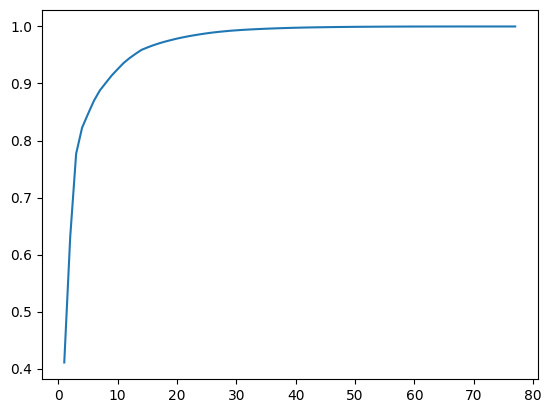

In [367]:
sns.lineplot(x=np.arange(1, len(evr)+1), y=np.cumsum(evr))

In [371]:
pcaer = PCA(13).fit(pr_norm)

Now we're talking! The first 13 axes capture 95% of variance.

In [377]:
xpca = pd.DataFrame(pcaer.transform((Xpdmo - pca_offset) / pca_ratio), index=Xpdmo.index,
                   columns=[f"ax{i}" for i in range(13)])
xpca

,ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11,ax12
id,,,,,,,,,,,,,
01010000,-6.405055,-4.071039,-5.080241,1.201262,1.004377,-1.331016,0.642992,-0.179714,-0.678802,-0.122822,0.673541,0.377024,-1.185492
01011000,-5.848932,-3.909662,-4.526558,1.094091,0.763225,-1.394702,0.720341,1.021870,-0.720458,0.382478,1.038708,-0.001068,-0.478822
01018035,-4.418510,-3.092817,-4.344565,0.010752,1.798220,-1.087727,0.466230,0.059686,-0.486458,-0.738696,0.533244,1.334722,-1.123957
01038000,-2.717813,-3.354823,-3.381141,0.793932,1.402195,-1.003846,0.640930,0.873549,-0.479765,0.050402,0.705916,0.719283,-0.253332
010642505,-5.455998,-2.632835,-2.535193,3.361218,-0.258898,-0.953041,0.629485,-0.604991,-0.696744,0.056905,0.846951,0.177626,-0.825569
...,...,...,...,...,...,...,...,...,...,...,...,...,...
301141089320300,11.339148,1.090344,2.667890,1.321142,1.134947,0.100907,2.336478,2.867565,0.425348,-0.323651,-0.586135,-0.859381,-1.140705
383926107593001,-4.522659,9.353134,-0.884262,-1.713012,-0.383770,1.567769,-1.933048,0.023668,1.073652,-1.948009,2.036957,1.833767,1.626179
394220106431500,-9.100265,6.352765,0.365057,4.922681,0.713242,0.323863,-1.684118,-0.354316,0.751614,0.348454,-1.118026,-0.497092,-0.542747


In [382]:
comp = pd.DataFrame(pcaer.components_.transpose(), index=Xpdmo.columns, columns=[f"ax{i}" for i in range(13)])
comp

,ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11,ax12
intercept_tm,0.163182,0.075251,0.051920,-0.069137,-0.044161,0.019333,0.028413,0.004620,-0.019302,-0.023483,0.072110,0.051616,0.026687
ksin_tm,0.110085,0.038275,0.153104,0.137294,0.023708,0.118764,0.097548,-0.080872,-0.063771,0.091680,-0.153750,-0.198042,0.262734
kcos_tm,0.065079,0.030819,0.257469,0.074443,0.096369,-0.028998,0.019396,-0.091622,-0.037127,0.073704,-0.024639,-0.029533,0.098590
intercept_vp,0.173338,-0.039400,-0.003074,0.022285,0.037137,0.010009,-0.041879,0.017562,0.030713,0.018337,-0.074701,-0.038156,-0.069457
ksin_vp,-0.106724,0.059274,0.179768,-0.116713,-0.008015,-0.163543,-0.085995,-0.001117,0.080677,0.090642,0.152229,-0.130685,-0.076322
...,...,...,...,...,...,...,...,...,...,...,...,...,...
vp_8,0.160285,-0.058075,-0.086018,0.056561,-0.011716,0.070988,-0.023311,0.027145,-0.017694,0.009534,-0.082987,0.016277,-0.049855
vp_9,0.165072,-0.040849,-0.066377,0.078326,0.015044,0.077780,-0.003417,0.019286,0.007483,0.002385,-0.112291,-0.004144,-0.014561
vp_10,0.169377,-0.036808,-0.008099,0.056046,0.090203,0.020424,0.004903,-0.016496,0.004141,-0.063029,-0.121090,-0.019823,-0.010132
vp_11,0.156391,-0.014561,0.094527,-0.030219,0.169175,-0.032070,0.016150,-0.022719,0.017732,-0.043732,-0.112535,0.009936,-0.027113


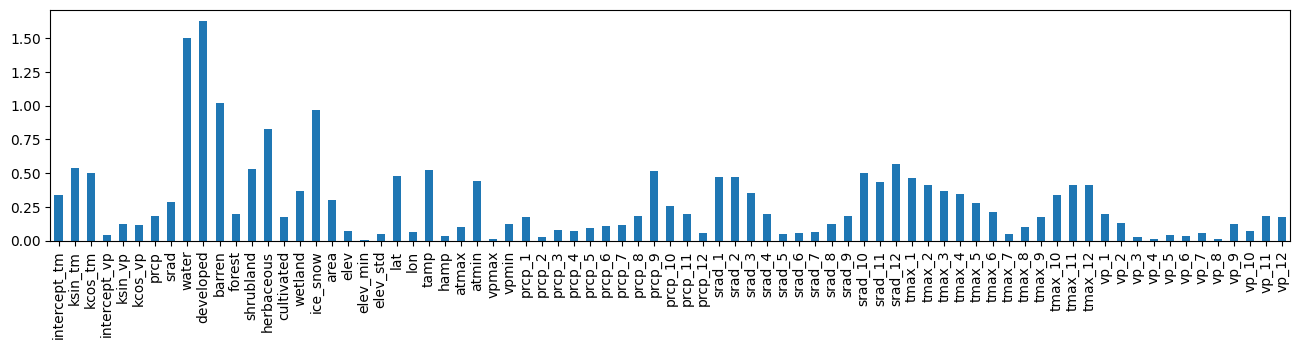

In [396]:
fig = plt.figure(figsize=(16, 3))
ax = plt.axes()
tot_weight = abs(comp.sum(axis=1))
_ = tot_weight.plot.bar(ax=ax)

## Intercept

In [271]:
y = Xmo["Intercept"].to_numpy()

First, let's look at the spatial pattern and partial dependencies.  In XY, partial dependency is principally north-south, but it drops off on the coasts.  It's quite linear with elevation.

In [272]:
X = Xpdmo[["lat", "lon", "elev", "elev_std"]].to_numpy()
gam = LinearGAM(te(0, 1, lam=0.1) + l(2)).fit(X, y)
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     28.9012
Link Function:                     IdentityLink Log Likelihood:                                 -2834.5995
Number of Samples:                          859 AIC:                                             5729.0014
                                                AICc:                                            5731.2329
                                                GCV:                                               10.9836
                                                Scale:                                             10.3204
                                                Pseudo R-Squared:                                   0.5433
Feature Function                  Lam

C:\Users\dphilippus\AppData\Local\Temp\ipykernel_21740\3288480058.py:3: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


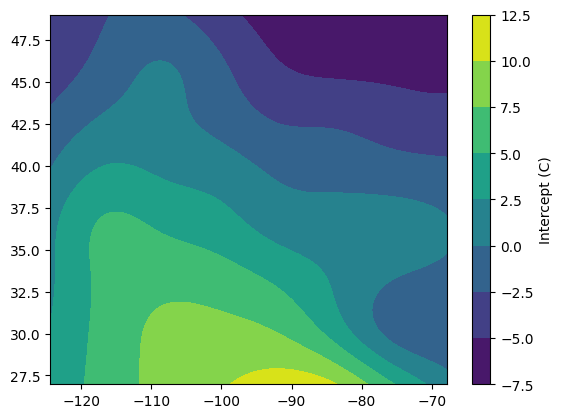

In [273]:
xg = gam.generate_X_grid(term=0, meshgrid=True)
Z = gam.partial_dependence(term=0, X=xg, meshgrid=True)
co = plt.contourf(xg[1], xg[0], Z)
plt.colorbar(co, label="Intercept (C)")
plt.savefig("results/SpatialPD.png")

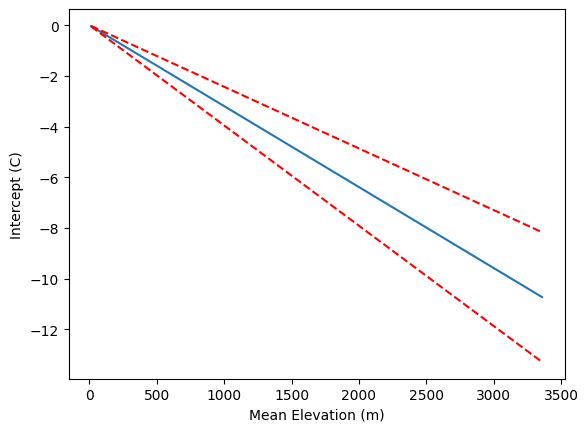

In [274]:
xg = gam.generate_X_grid(term=1)
pdep, confi = gam.partial_dependence(term=1, X=xg, width=0.95)
ax = plt.plot(xg[:,2], pdep)
plt.plot(xg[:,2], confi, c='r', ls='--')
plt.xlabel("Mean Elevation (m)")
plt.ylabel("Intercept (C)")
plt.savefig("results/ElevPD.png")

Now let's try throwing everything in there, stepwise-like.

In [275]:
Xpdmo.columns

Index(['intercept_tm', 'ksin_tm', 'kcos_tm', 'intercept_vp', 'ksin_vp',
       'kcos_vp', 'prcp', 'srad', 'water', 'developed', 'barren', 'forest',
       'shrubland', 'herbaceous', 'cultivated', 'wetland', 'ice_snow', 'area',
       'elev', 'elev_min', 'elev_std', 'lat', 'lon', 'tamp', 'hamp', 'atmax',
       'atmin', 'vpmax', 'vpmin', 'prcp_1', 'prcp_2', 'prcp_3', 'prcp_4',
       'prcp_5', 'prcp_6', 'prcp_7', 'prcp_8', 'prcp_9', 'prcp_10', 'prcp_11',
       'prcp_12', 'srad_1', 'srad_2', 'srad_3', 'srad_4', 'srad_5', 'srad_6',
       'srad_7', 'srad_8', 'srad_9', 'srad_10', 'srad_11', 'srad_12', 'tmax_1',
       'tmax_2', 'tmax_3', 'tmax_4', 'tmax_5', 'tmax_6', 'tmax_7', 'tmax_8',
       'tmax_9', 'tmax_10', 'tmax_11', 'tmax_12', 'vp_1', 'vp_2', 'vp_3',
       'vp_4', 'vp_5', 'vp_6', 'vp_7', 'vp_8', 'vp_9', 'vp_10', 'vp_11',
       'vp_12'],
      dtype='object')

In [282]:
gam.statistics_["AIC"]

5729.001360705617

In [437]:
gam_itx = runit(Xpdmo, Xmo["Intercept"].to_numpy(), latlon=True)

Added tmax_10 with delta  0.000
Added tmax_12 with delta  0.084
Added tmax_3 with delta  0.045
Added vp_2 with delta  0.042
Added tmax_1 with delta  0.027
Added ksin_tm with delta  0.024
Added vp_11 with delta  0.020
               r2        gcv          aic  delta_r2
tmax_4   0.785552   6.266696  4724.191576  0.018183
vp_11    0.767369   6.560490  4815.739644  0.020413
ksin_tm  0.746956   6.917010  4916.223518  0.023843
tmax_1   0.723112   7.280616  5018.200798  0.026759
vp_2     0.696354   7.719150  5129.163844  0.041703
tmax_3   0.654651   8.482552  5298.290280  0.045179
tmax_12  0.609472   9.251518  5456.785191  0.084086
tmax_10  0.525386  10.822665  5731.212093  0.000000


Optimal intercept-GAM (r2 0.80) has vp_11, 12, 2 and tmax_3, 4, 12 plus lat/lon.  Next step is to look at the PDPs and try to nail down specific relationships.

We see the following:

- Strictly north-south intercept
- March mean teperature has a threshold response, with a huge effect for >20 C.
- December mean temperature has almost exactly the negation of that effect. Weird.
- February vapor pressure has a huge spike from 1000-1500 and otherwise little effect.
- April temperature behaves like December temperature, but the threshold is about 25 C.
- December and November vapor pressure are both roughly constant up to ~900, then a dip (large for Dec, small for Nov), then a spike.

The temperatures and VPs suggest looking at categorical breaks about 20 C (March, April, December) and 1000 Pa (November, December, February).

Summary: look at winter-spring mean tmax.

Performance is considerably worse with PCA (maximum r2 0.61).  Trying to force it to use "smart" variables does not seem to improve performance or GCV, so what we have to do is try to constrain the relationships.

IndexError: tuple index out of range

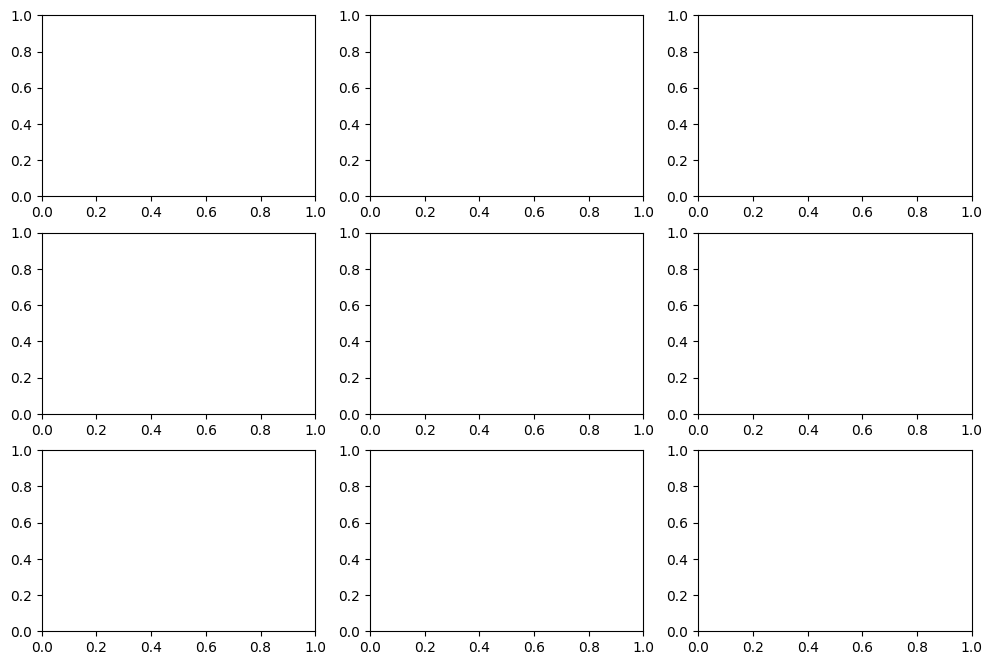

In [438]:
pdps(gam_itx)

## Amplitude

In [405]:
gam_amp = runit(xpca, Xmo["Amplitude"].to_numpy())

Added ax2 with delta  0.000
Added ax0 with delta  0.046
Added ax12 with delta  0.024
            r2       gcv          aic  delta_r2
ax1   0.591457  3.450105  3885.777611  0.013874
ax12  0.577583  3.433628  3896.630995  0.023541
ax0   0.554042  3.487791  3937.063934  0.045957
ax2   0.508085  3.696597  4040.530792  0.000000


Optimal GAM (r2 0.65) has wetland, vapor pressure cosine coefficient, and min elevation.

- Amplitude is largest in the south.
- Amplitude decreases in a somewhat stepwise, inconsistent fashion with increasing min elevation. A decent approximation would be constant up to 1200 m, then linear at about 3 C per km.
- Vapor pressure amplitude has a noisily logarithmic relationship.
- Wetland abundance also seems noisily logarithmic.

Performance is a bit worse with PCA (r2 0.59).

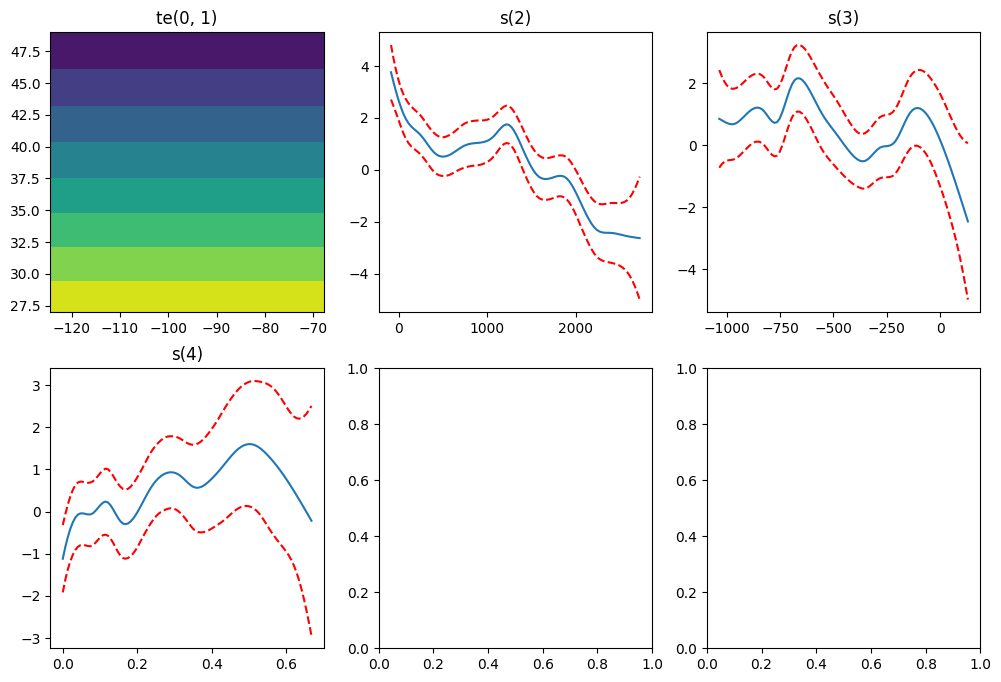

In [340]:
pdps(gam_amp)

## SpringSummer

In [406]:
gam_ssu = runit(xpca, Xmo["SpringSummer"].to_numpy())

Added ax0 with delta  0.000
Added ax2 with delta  0.047
Added ax6 with delta  0.034
Added ax4 with delta  0.025
Added ax1 with delta  0.026
           r2       gcv          aic  delta_r2
ax7  0.509092  0.704769  2162.513227  0.015731
ax1  0.493360  0.705060  2168.037789  0.025604
ax4  0.467757  0.713533  2179.689592  0.024871
ax6  0.442886  0.720289  2190.275281  0.033866
ax2  0.409020  0.735792  2207.397787  0.047490
ax0  0.361529  0.763571  2234.824867  0.000000


Optimal GAM (r2 0.57) has wetland, June precip, and tmax 1, 2, 6.

- Once again, a strong north-south gradient in space.
- June air temperature has a powerful negative (linearish) relationship.
- February air temperature does a down-then-up thing.
- January air temperature is the reverse of February, so I suspect there's a combined winter effect that does less.
- June precipitation is linear-constant-linear (increasing) with breaks at 3 and 6 mm/day.
- Wetland relationship looks like noise.

Performance is worse with PCA, max r2 0.51.

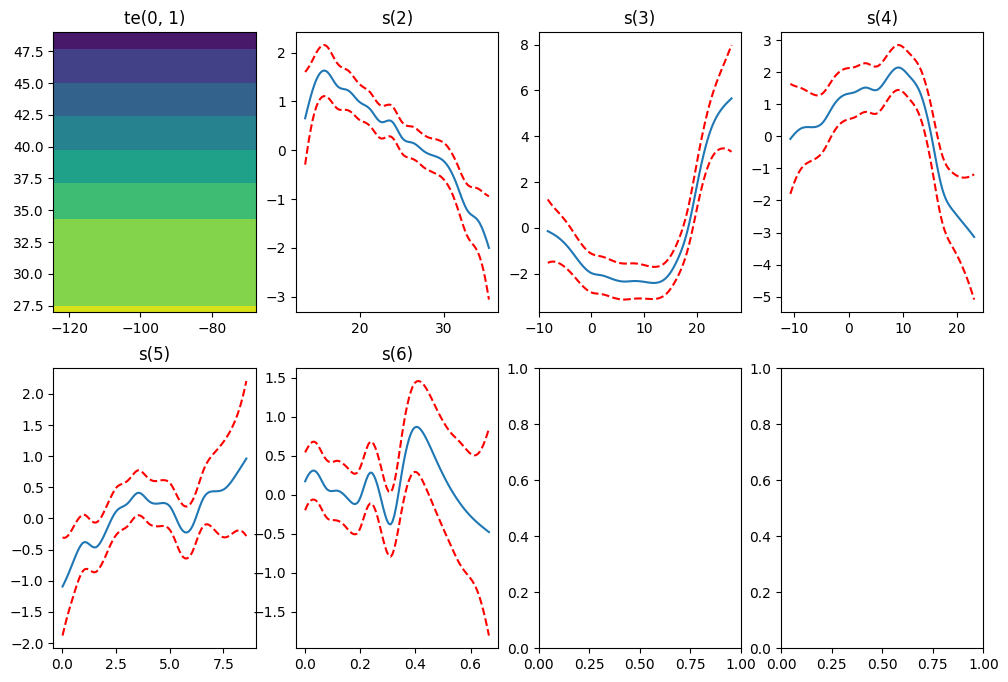

In [341]:
pdps(gam_ssu)

## FallWinter

In [317]:
gam_fw = runit(Xmo["FallWinter"].to_numpy())

Added tmax_3 with delta  0.053
Added water with delta  0.036
Added wetland with delta  0.039
Added srad_8 with delta  0.027
Added srad_4 with delta  0.023
                r2       gcv          aic  delta_r2
elev_min  0.555605  0.483374  2112.707838  0.017697
srad_4    0.537908  0.483826  2112.011972  0.023345
srad_8    0.514563  0.489234  2109.661999  0.027314
wetland   0.487249  0.496695  2107.601839  0.039458
water     0.447791  0.518125  2105.367293  0.036210
tmax_3    0.411581  0.536793  2107.018723  0.052612


Optimal GAM (r2 0.56) has elev_min, srad_4,8, wetland, water, and tmax_3.

- I'm wondering if there's a bug with the north-south thing or if east-west is just reliably captured elsewhere.
- March air temperature is more or less linear (increasing) after 10 C.
- Water abundance has a strong decline until 0.02 or so, then noise.  Looking at square-root-abundance could be useful.
- Wetlands have a logarithmic response.
- August sunshine looks like noise/overfitting.
- April sun, on the other hand, has a big threshold effect around 550 W/m2.
- Elevation looks noisy, possibly with a decreasing linear term (that's the wrong direction).

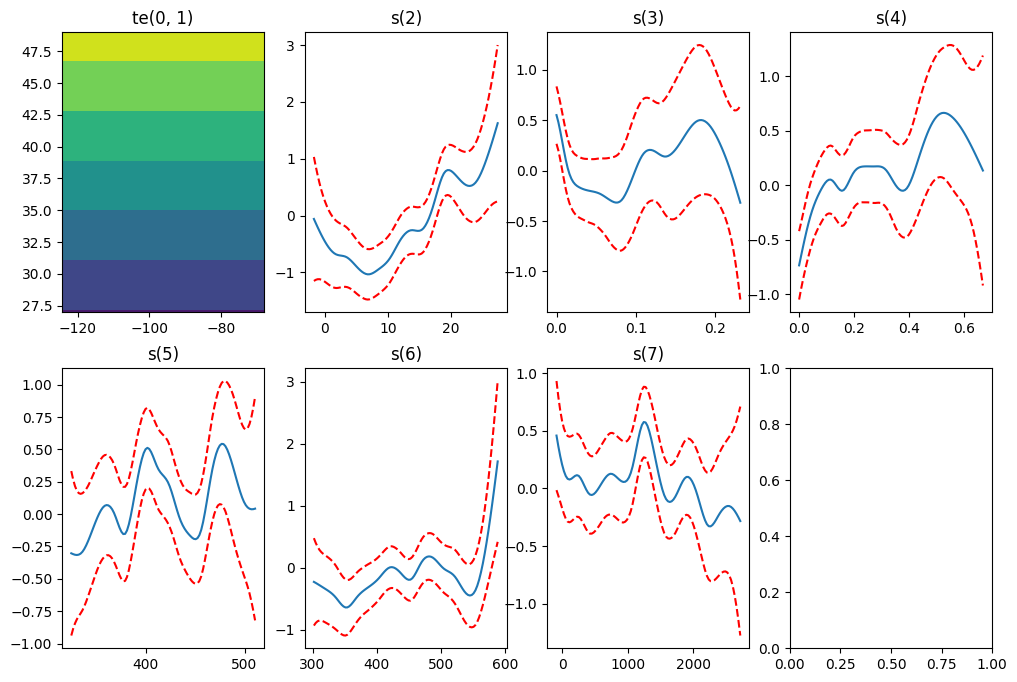

In [342]:
pdps(gam_fw)

## SpringDay

In [318]:
gam_spd = runit(Xmo["SpringDay"].to_numpy())

Added tmax_4 with delta  0.047
Added tmax_3 with delta  0.062
Added elev_std with delta  0.028
                r2         gcv           aic  delta_r2
prcp_4    0.476807  319.249036  11361.534502  0.017445
elev_std  0.459362  317.783316  11375.093434  0.027686
tmax_3    0.431676  322.915473  11421.582221  0.061805
tmax_4    0.369871  345.386252  11556.662346  0.046942


Optimal GAM (r2 0.48) has prcp_4, elev_Std, tmax_3 and 4.  Side comment: we should expect logistic relationships for dates, since they have a fixed range.

- North-south
- Strong linear trend with April air temperature between 10 and 25 C, otherwise constant (~logistic)
- Logistic negative trend with March air temperature between about 5 and 20 C.  Note pretty good offset between March/April, probably a mean.
- Sort of steppish decline (earlier) with elevation, could be modeled by exponential decay (~constant by ~800 m).
- Threshold response to April precip (up to 2 mm/day), then constant.

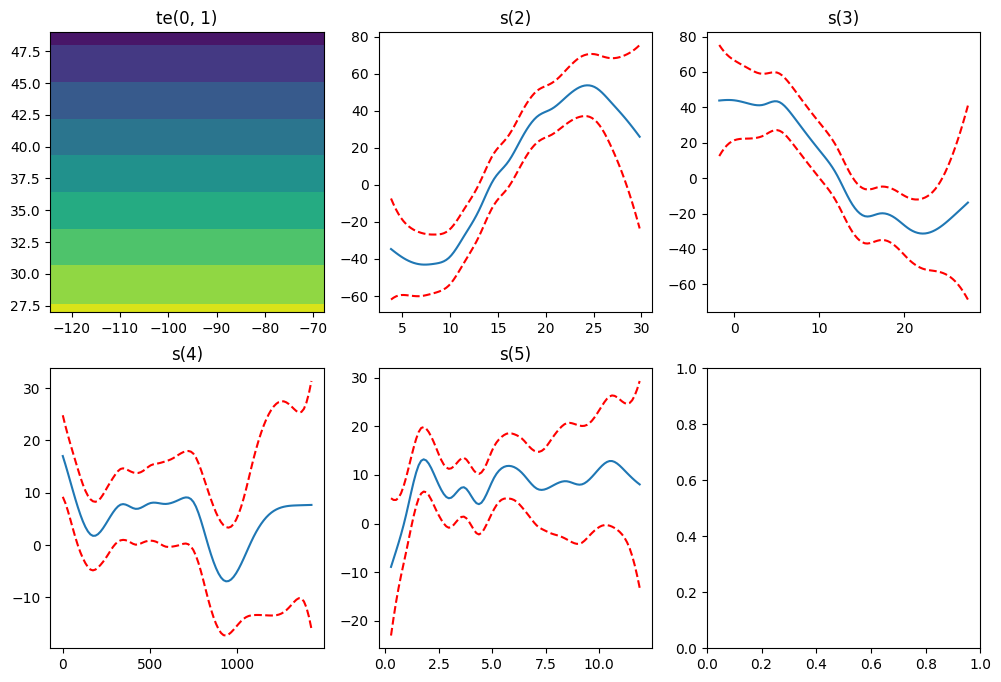

In [343]:
pdps(gam_spd)

## SummerDay

In [319]:
gam_sud = runit(Xmo["SummerDay"].to_numpy())

Added tmax_7 with delta  0.048
Added tmax_9 with delta  0.040
Added elev_std with delta  0.030
Added cultivated with delta  0.028
Added tmax_8 with delta  0.023
Added vp_5 with delta  0.023
                  r2         gcv           aic  delta_r2
water       0.396410  255.662999  10912.606713  0.019499
vp_5        0.376911  256.068889  10933.913449  0.022750
tmax_8      0.354161  254.982914  10950.808314  0.022965
cultivated  0.331195  254.905904  10971.060971  0.027754
elev_std    0.303442  254.832246  10994.132292  0.030231
tmax_9      0.273210  257.020990  11027.857785  0.040151
tmax_7      0.233059  260.976130  11075.152029  0.047889


Optimal GAM (r2 0.40) has water, vp_5, tmax_8,9,7, cultivated, and elev_std.

- North-south
- Solid linear drop (or logisticish) with July temperatures
- Reverse pattern with September and August temperatures; consider summer mean
- Noisy elevation response, could be logarithmic or constant
- Constant with cultivated, that's noise
- vp looks like noise
- Water looks like noise, maybe a slight increase.  Try linear.

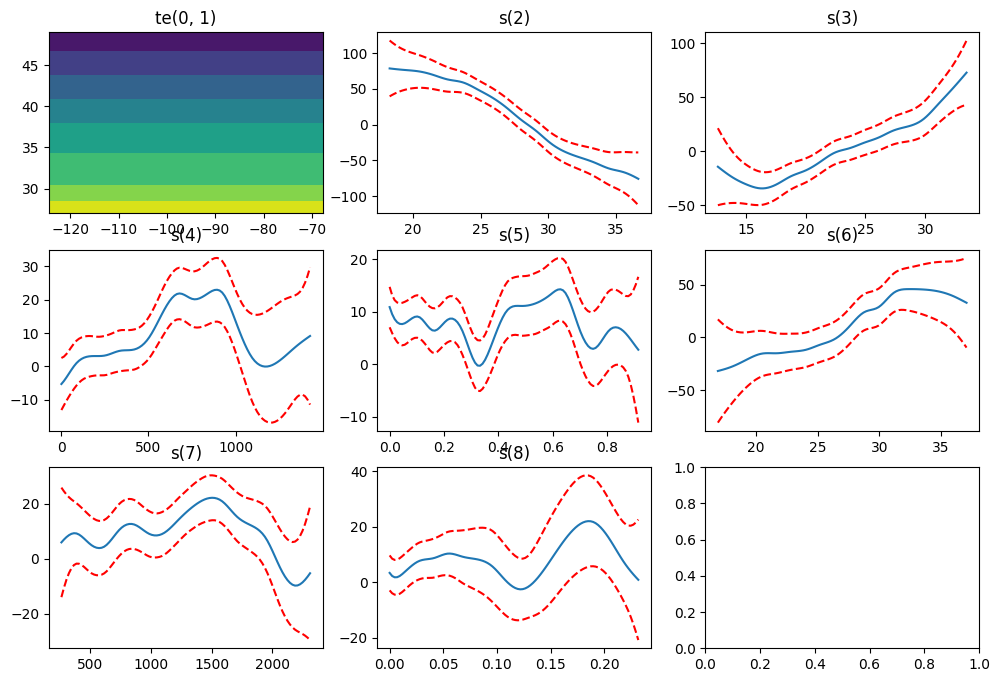

In [344]:
pdps(gam_sud)

## FallDay

In [320]:
gam_fd = runit(Xmo["FallDay"].to_numpy())

Added water with delta  0.087
Added srad_4 with delta  0.033
Added elev with delta  0.027
Added tmax_2 with delta  0.027
Added tmax_12 with delta  0.023
               r2         gcv           aic  delta_r2
srad_1   0.419340  181.790446  10354.914121  0.019170
tmax_12  0.400171  181.092620  10370.060946  0.022794
tmax_2   0.377376  181.157864  10392.291498  0.027498
elev     0.349879  182.168469  10423.343100  0.026612
srad_4   0.323267  182.458527  10447.549775  0.033108
water    0.290159  184.322369  10485.392092  0.086969


Optimal GAM (r2 0.42) has srad_1, 4, tmax_2, 12, elev, and water.

- North-south
- Logarithmic response with water
- Solid negative linear with April solar radiation
- Linearish with elevation; big drop at 3000 m, but too few up there to be sure
- Solid positive linear with February air temperature
- Negative response to December air, not quite canceling out - consider winter air temp
- Logarithmic response with January solar radiation

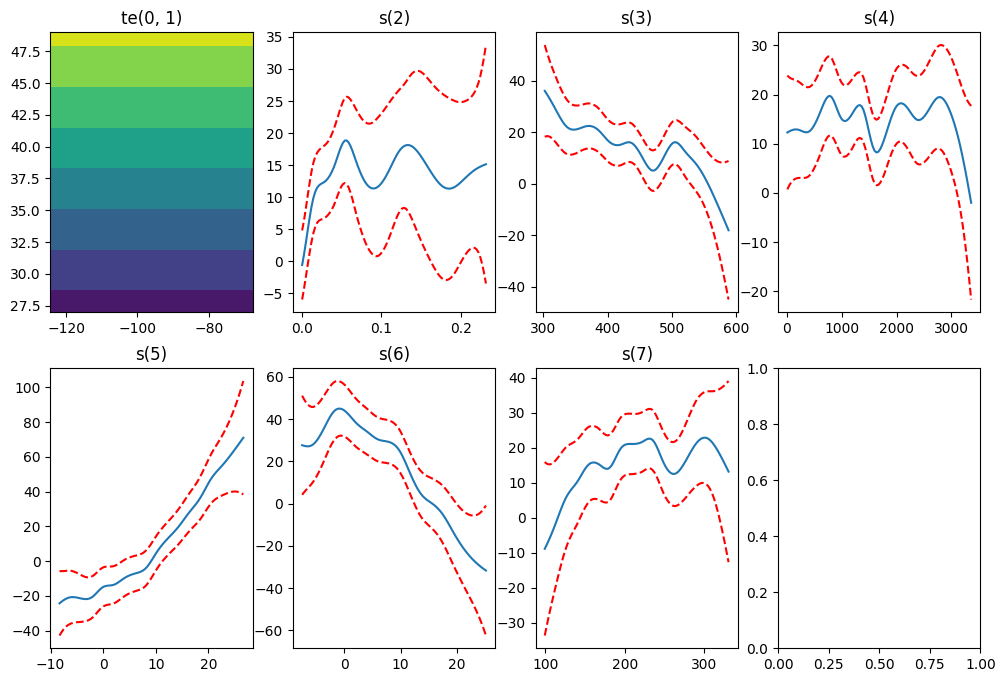

In [345]:
pdps(gam_fd)

## WinterDay

In [321]:
gam_wd = runit(Xmo["WinterDay"].to_numpy())

Added intercept_tm with delta  0.089
Added elev_std with delta  0.028
Added prcp_2 with delta  0.023
                    r2         gcv           aic  delta_r2
srad_10       0.506934  677.018594  12650.897800  0.015470
prcp_2        0.491463  671.712426  12659.645398  0.023359
elev_std      0.468104  677.440885  12694.627880  0.028354
intercept_tm  0.439750  690.092490  12744.688157  0.088929


Optimal GAM (r2 0.51) has srad_10, prcp_2, elev_std, and intercept_tm.

- North-south
- Logarithmic with mean tmax
- Noisy with elevation, looks like it's fitting random spots.  Maybe linear/logistic is worth a shot.
- Noisy-constant with precip
- Noisy-constant with srad.

Summary: spatial and tmax-mean pretty much cover it.

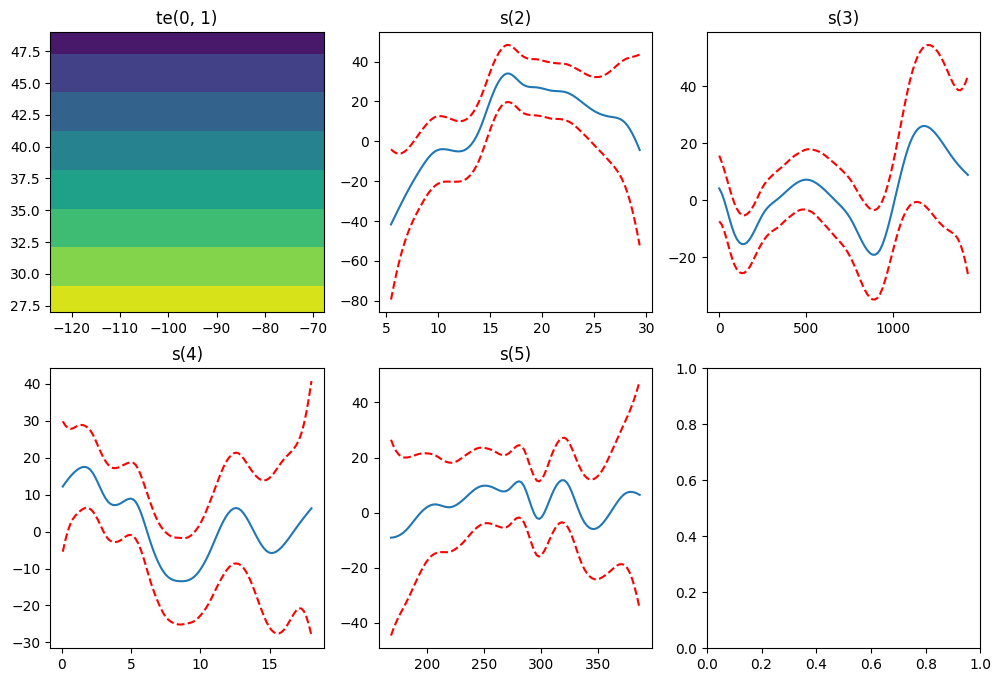

In [346]:
pdps(gam_wd)

## Tmax

In [322]:
gam_at = runit(Xmo["at_coef"].to_numpy())

Added vp_4 with delta  0.072
Added intercept_vp with delta  0.121
Added vp_12 with delta  0.055
Added vp_3 with delta  0.050
Added vp_2 with delta  0.047
Added ksin_tm with delta  0.040
Added forest with delta  0.021
Added water with delta  0.023
                    r2       gcv           aic  delta_r2
area          0.676189  0.021413  40239.574841  0.017174
water         0.659015  0.021821  38966.282436  0.022541
forest        0.636473  0.022567  37163.438814  0.020924
ksin_tm       0.615549  0.022772  36203.595385  0.040208
vp_2          0.575342  0.024224  33399.718866  0.046544
vp_3          0.528798  0.026067  30492.607014  0.050454
vp_12         0.478344  0.027909  27960.883955  0.054588
intercept_vp  0.423756  0.029846  25677.054547  0.120631
vp_4          0.303125  0.034867  21344.038544  0.071955


Optimal GAM (r2 0.68) has area, water, forest, ksin_tm, intercept_vp, and vp_2,3,4,12.

- North-south
- Bunch of opposing thresholds to the five VPs, consider some sort of mean.
- Threshold response to air-T sine amplitude
- Noisy decline with forested area, looks like constant to 0.3 then linear
- Noisy decrease-then-increase with water, not sure how to model that
- Noisy increase with area

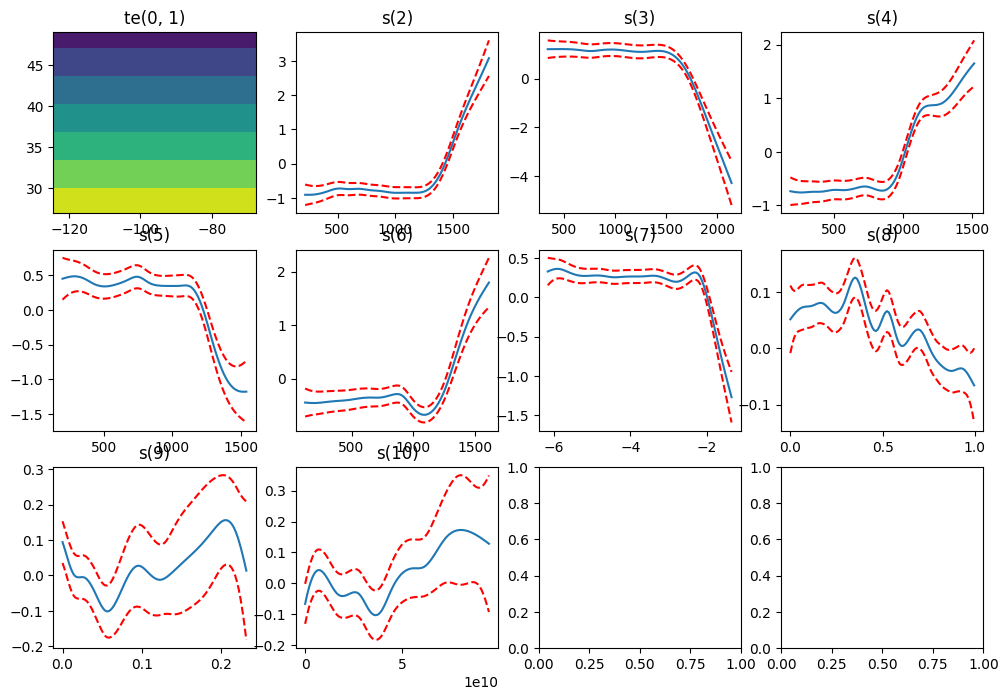

In [347]:
pdps(gam_at)

## vp

In [323]:
gam_vp = runit(Xmo["vp_coef"].to_numpy())

Added tmax_2 with delta  0.095
Added tmax_12 with delta  0.126
Added vp_11 with delta  0.116
Added vp_4 with delta  0.061
Added vp_3 with delta  0.076
Added vp_2 with delta  0.062
Added srad_12 with delta  0.025
Added vp_12 with delta  0.023
Added ksin_tm with delta  0.026
Added vp_5 with delta  0.022
               r2           gcv           aic  delta_r2
srad_10  0.761786  8.234137e-07  1.209963e+09  0.014691
vp_5     0.747095  8.393964e-07  1.170906e+09  0.021617
ksin_tm  0.725478  8.797700e-07  1.104315e+09  0.026375
vp_12    0.699103  9.283521e-07  1.033633e+09  0.022921
srad_12  0.676182  9.710610e-07  9.791469e+08  0.025408
vp_2     0.650775  1.006953e-06  9.325001e+08  0.061557
vp_3     0.589218  1.150633e-06  8.086386e+08  0.076180
vp_4     0.513038  1.318135e-06  6.983856e+08  0.061102
vp_11    0.451936  1.430999e-06  6.361961e+08  0.115758
tmax_12  0.336178  1.681096e-06  5.365306e+08  0.126170
tmax_2   0.210007  1.930193e-06  4.622729e+08  0.095128


Optimal GAM (r2 0.76) has srad_10,12, vp_2,3,4,5,12, tmax_2,12, and ksin_tm.  It's all weather, basically.

- North-south
- Linearish with February air
- Threshold response with December air
- Thresholds with November-Dec and Feb-May humidity, use winter-spring mean
- Noisy srad response
- Threshold response to ksin-air
- Noisy decline with October srad

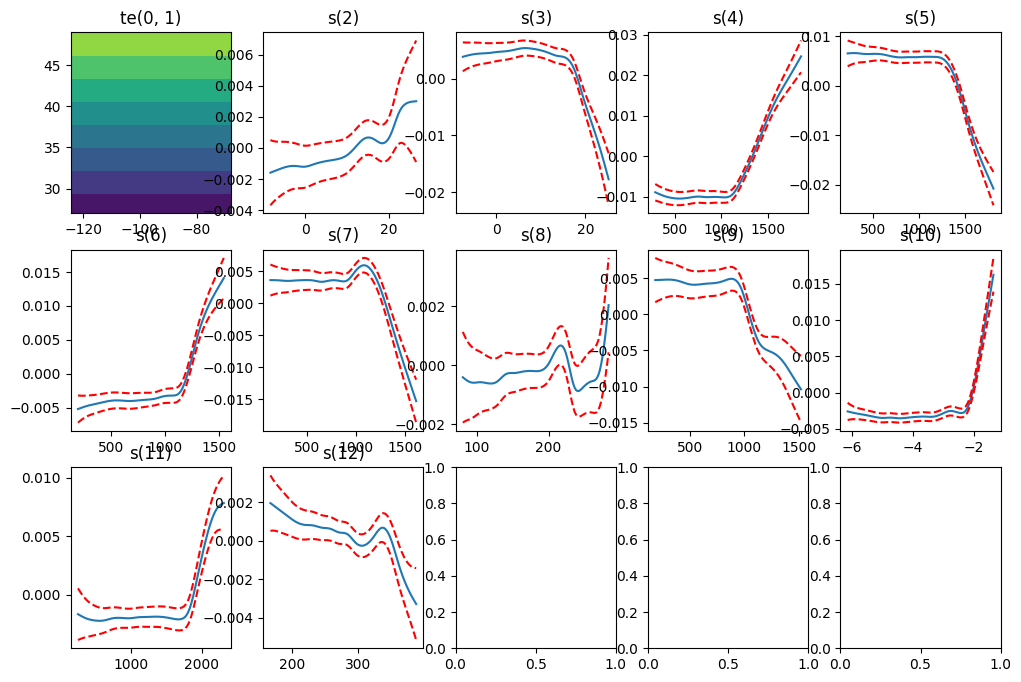

In [348]:
pdps(gam_vp)

# Cross-Validation Test

Right, we've got some approaches laid out.  Let's test it!  In general, naive GAMs solidly outperform the linear models, so we'll start with those.

## Naive GAMs

In [2]:
itx_var = ["lat", "lon", "tmax_3", "tmax_4", "tmax_12", "vp_2", "vp_11", "vp_12"]
amp_var = ["lat", "lon", "wetland", "kcos_vp", "elev_min"]
ssu_var = ["lat", "lon", "wetland", "prcp_6", "tmax_1", "tmax_2", "tmax_6"]
fw_var = ["lat", "lon", "elev_min", "srad_4", "srad_8", "wetland", "water", "tmax_3"]
spd_var = ["lat", "lon", "prcp_4", "elev_std", "tmax_3", "tmax_4"]
sud_var = ["lat", "lon", "water", "vp_5", "tmax_8", "cultivated", "elev_std", "tmax_9", "tmax_7"]
fad_var = ["lat", "lon", "srad_1", "tmax_12", "tmax_2", "elev", "srad_4", "water"]
wid_var = ["lat", "lon", "srad_10", "prcp_2", "elev_std", "intercept_tm"]
at_var = ["lat", "lon", "area", "water", "forest", "ksin_tm", "vp_2", "vp_3", "vp_12", "intercept_vp", "vp_4"]
vp_var = ["lat", "lon", "srad_10", "vp_5", "ksin_tm", "vp_12", "srad_12", "vp_2", "vp_3", "vp_4", "vp_11", "tmax_12", "tmax_2"]
shared = list(set(itx_var + amp_var + ssu_var + fw_var + spd_var + sud_var + fad_var + wid_var + at_var + vp_var))
names = ["Intercept", "Amplitude", "SpringSummer", "FallWinter", "SpringDay", "SummerDay", "FallDay", "WinterDay", "at_coef", "vp_coef"]

In [3]:
# gam_data = data[["id", "date", "temperature", "vp", "tmax"]].merge(Xmo, on="id")
# gam_data.to_csv("MergedData.csv")
gam_data = pd.read_csv("MergedData.csv", dtype={"id": "str"})
gam_data["date"] = pd.to_datetime(gam_data["date"])
gam_data["day"] = gam_data["date"].dt.day_of_year

In [6]:
cd = gam_data.groupby("id")[shared + names].mean()
g = LinearGAM(build_eq(len(itx_var), True)).fit(cd[itx_var], cd["Intercept"].to_numpy())
g.predict(cd[itx_var])[0]

9.15492775691442

In [13]:
wst = gam_data[gam_data["id"] == gam_data["id"].iloc[0]]
wst[shared].mean().to_frame().T

,prcp_6,vp_3,tmax_12,srad_1,lon,tmax_1,tmax_3,srad_4,tmax_9,tmax_8,...,wetland,cultivated,water,tmax_2,elev_std,vp_4,tmax_7,tmax_6,vp_11,prcp_2
0,1.063464,275.2133,-4.053537,254.91296,-110.178722,-2.779675,3.363886,515.61234,16.454326,20.382895,...,0.04023,0.0,0.000756,-3.85792,130.430969,336.044278,21.702253,16.458075,284.830735,3.405588


In [17]:
def gam_modbuilder(data):
    print("preparing data")
    cd = data.groupby("id")[shared + names].mean()
    builder = lambda cols, yn: LinearGAM(build_eq(len(cols), True)).fit(cd[cols], cd[yn].to_numpy())
    predictor = lambda cols, gam, ws: gam.predict(ws[cols])[0]
    print("Training models")
    gam_itx = builder(itx_var, "Intercept")
    gam_amp = builder(amp_var, "Amplitude")
    gam_ssu = builder(ssu_var, "SpringSummer")
    gam_fw = builder(fw_var, "FallWinter")
    gam_spd = builder(spd_var, "SpringDay")
    gam_sud = builder(sud_var, "SummerDay")
    gam_fad = builder(fad_var, "FallDay")
    gam_wid = builder(wid_var, "WinterDay")
    gam_at = builder(at_var, "at_coef")
    gam_vp = builder(vp_var, "vp_coef")
    print("Trained models")
    def runner(ws):
        # print(f"Running {ws['id'].iloc[0]}")
        # try:
        at_day = ws.groupby(["day"], as_index=False)["tmax"].mean().rename(columns={"tmax": "mean_tmax"})
        vp_day = ws.groupby(["day"], as_index=False)["vp"].mean().rename(columns={"vp": "mean_vp"})
        statics = ws[shared].mean().to_frame().T
        model = Watershed(seasonality=rts.ThreeSine(
            Intercept=predictor(itx_var, gam_itx, statics),
            Amplitude=predictor(amp_var, gam_amp, statics),
            SpringSummer=predictor(ssu_var, gam_ssu, statics),
            FallWinter=predictor(fw_var, gam_fw, statics),
            SpringDay=predictor(spd_var, gam_spd, statics),
            SummerDay=predictor(sud_var, gam_sud, statics),
            FallDay=predictor(fad_var, gam_fad, statics),
            WinterDay=predictor(wid_var, gam_wid, statics)
        ),
                          at_coef=predictor(at_var, gam_at, statics),
                          vp_coef=predictor(vp_var, gam_vp, statics),
                          at_day=at_day,
                          vp_day=vp_day)
        return model.run_series(ws)
        # except Exception as e:
        #     print(e)
    return runner

In [18]:
kfr = kfold(gam_data, gam_modbuilder, output="results/NaiveGAM.csv")

preparing data
Training models
Trained models
preparing data
Training models
Trained models
preparing data
Training models
Trained models
preparing data
Training models
Trained models
preparing data
Training models
Trained models


/home/jovyan/.local/lib/python3.11/site-packages/rtseason/seasons.py:18: RuntimeWarning: divide by zero encountered in divide
  return np.sin(((days - start) % 365) * 2 * np.pi / len(domain)) * \
/home/jovyan/.local/lib/python3.11/site-packages/rtseason/seasons.py:18: RuntimeWarning: invalid value encountered in sin
  return np.sin(((days - start) % 365) * 2 * np.pi / len(domain)) * \
/home/jovyan/.local/lib/python3.11/site-packages/rtseason/seasons.py:18: RuntimeWarning: divide by zero encountered in divide
  return np.sin(((days - start) % 365) * 2 * np.pi / len(domain)) * \
/home/jovyan/.local/lib/python3.11/site-packages/rtseason/seasons.py:18: RuntimeWarning: invalid value encountered in sin
  return np.sin(((days - start) % 365) * 2 * np.pi / len(domain)) * \


preparing data
Training models
Trained models
preparing data
Training models
Trained models
preparing data
Training models
Trained models
preparing data
Training models
Trained models
preparing data
Training models
Trained models


In [20]:
perf_summary(kfr)

,R2,RMSE,NSE,Pbias,Bias,MaxMiss
0,0.694139,4.719429,0.692002,2.082688,0.268983,5.390829


In [22]:
kfr.groupby("id").apply(perf_summary, include_groups=False).median()

/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


R2         0.944026
RMSE       2.218157
NSE        0.893316
Pbias      2.413418
Bias       0.308628
MaxMiss    2.774715
dtype: float64

In [34]:
rng = np.random.default_rng()
ids = rng.choice(kfr["id"].unique(), 8)

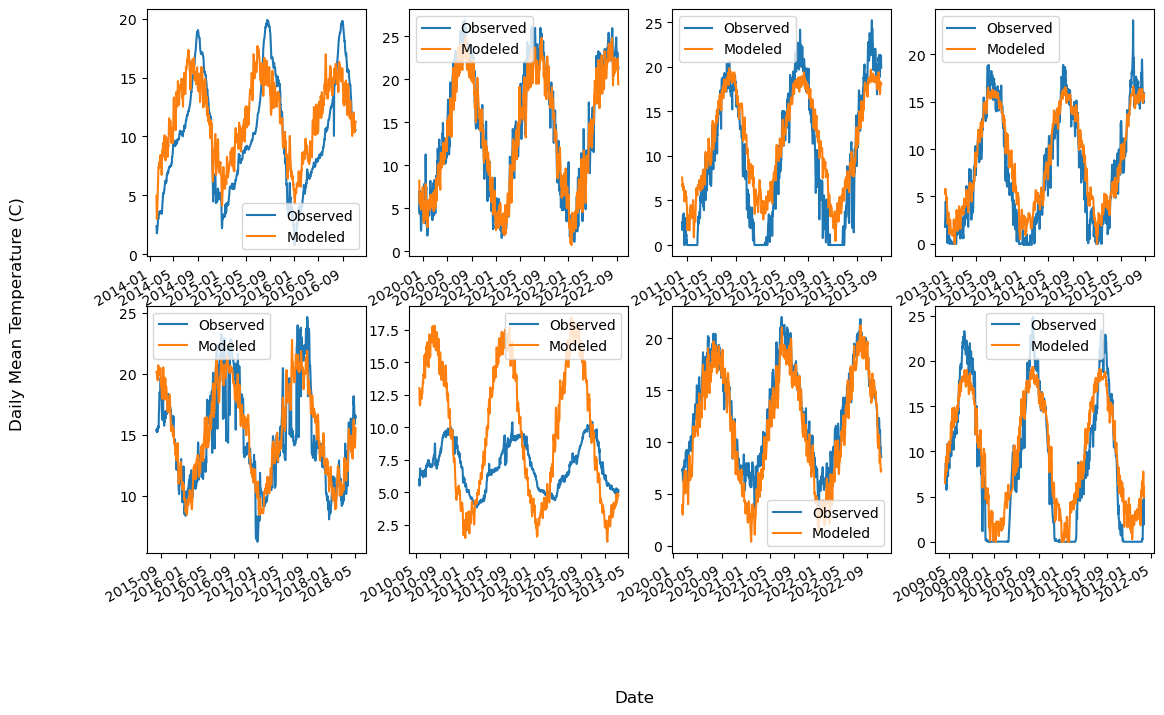

In [39]:
Ny = 2
Nx = 4
fig, axes = plt.subplots(Ny, Nx, figsize=(13, 8))
for i, ID in enumerate(ids):
    ax = axes[i // Nx, i % Nx]
    dat = kfr[kfr["id"] == ID]
    if len(dat) > 1100:
        start = rng.integers(0, len(dat) - 1000)
        dat = dat.iloc[start:(start + 1000), :]
    dat.plot(x="date", y="temperature", label="Observed", ax=ax)
    dat.plot(x="date", y="temp.mod", label="Modeled", ax=ax)
    ax.set_xlabel("")
    ax.set_ylabel("")

fig.supxlabel("Date")
_ = fig.supylabel("Daily Mean Temperature (C)")

plt.savefig("results/NaiveGAMSample.png", dpi=1000)